In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, mean_squared_error, r2_score)

from lightgbm import LGBMClassifier  # LightGBM
from xgboost import XGBClassifier  # XGBoost
from sklearn.ensemble import RandomForestClassifier  # Random Forest
from sklearn.naive_bayes import GaussianNB  # Naive Bayes
from sklearn.linear_model import LogisticRegressionCV  # Logistic Regression CV
from sklearn.svm import SVC  # SVC
from sklearn.neighbors import KNeighborsClassifier  # KNN
from sklearn.neural_network import MLPClassifier  # MLP (Neural Network)

# 其他必要的预处理/工具
from sklearn.preprocessing import StandardScaler, PolynomialFeatures  # 可选

import warnings
warnings.filterwarnings("ignore")

In [43]:
#解决matplotlib绘图中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['font.sans-serif'] = ['KaiTi']   # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False   # 解决保存图像是负号'-'显示为方块的问题

In [44]:
# 设置随机种子
random_seed = 42  
random.seed(random_seed)  # set random seed for python
np.random.seed(random_seed)  # set random seed for numpy

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse

def load_data(file_path):
    return pd.read_csv(file_path)

file_path = r"../tumordb/tumoragdb_data.csv"
data = load_data(file_path)

X = data.iloc[:, 2:]
y = data['immunogenicity']

# Use sparse matrix encoding for memory efficiency (262k features!)
print("Encoding features with sparse matrices...")
encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
X = encoder.fit_transform(X.astype(str))
print(f"✓ Encoded to {X.shape[1]:,} features (sparse format)")
print(f"✓ Memory efficiency: {X.nnz / (X.shape[0] * X.shape[1]) * 100:.2f}% non-zero")

In [ ]:
import pandas as pd
import numpy as np
import warnings
import os
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Ignore warnings
warnings.filterwarnings("ignore")

# ========== 1. Load data ==========
def load_data(file_path):
    return pd.read_csv(file_path)

file_path = r"../tumordb/tumoragdb_data.csv"
data = load_data(file_path)

# ========== 2. Preprocessing with SPARSE encoding ==========
X = data.iloc[:, 2:]
y = data['immunogenicity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Use sparse encoding - fit on train, transform both
print("Encoding with sparse matrices (memory efficient)...")
encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
X_train = encoder.fit_transform(X_train.astype(str))
X_test = encoder.transform(X_test.astype(str))
print(f"✓ Train: {X_train.shape[0]:,} samples × {X_train.shape[1]:,} features")
print(f"✓ Test:  {X_test.shape[0]:,} samples × {X_test.shape[1]:,} features")

# ========== 3. Models (lightened for memory) ==========
models = {
    "LightGBM": LGBMClassifier(n_estimators=50, random_state=42, verbose=-1),
    "XGBoost": XGBClassifier(n_estimators=50, random_state=42, eval_metric='logloss', verbosity=0),
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=1),
    "Naive Bayes (Gaussian)": GaussianNB(),
    "Logistic Regression CV": LogisticRegressionCV(cv=3, max_iter=1000, random_state=42),
    "SVC": SVC(probability=True, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "MLP (Neural Network)": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

# ========== 4. 5-fold cross-validation ==========
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

for name, model in models.items():
    print(f"Evaluating: {name}")
    try:
        y_pred = cross_val_predict(model, X_train, y_train, cv=kf)

        # Get probability predictions (for AUC)
        try:
            y_proba = cross_val_predict(model, X_train, y_train, cv=kf, method='predict_proba')[:, 1]
        except:
            try:
                y_proba = cross_val_predict(model, X_train, y_train, cv=kf, method='decision_function')
                y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
            except:
                y_proba = None

        cm = confusion_matrix(y_train, y_pred)
        TN, FP, FN, TP = cm.ravel() if cm.shape == (2, 2) else (0, 0, 0, 0)

        acc = accuracy_score(y_train, y_pred)
        prec = precision_score(y_train, y_pred, zero_division=0)
        rec = recall_score(y_train, y_pred, zero_division=0)
        f1 = f1_score(y_train, y_pred, zero_division=0)
        auc = roc_auc_score(y_train, y_proba) if y_proba is not None else None
        specificity = TN / (TN + FP) if (TN + FP) > 0 else None

        results.append({
            "Model": name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1 Score": f1,
            "AUC": auc,
            "Specificity": specificity,
            "TP": TP, "FP": FP, "TN": TN, "FN": FN
        })
    except Exception as e:
        print(f"Model {name} failed: {str(e)}")
        results.append({
            "Model": name,
            "Accuracy": None,
            "Precision": None,
            "Recall": None,
            "F1 Score": None,
            "AUC": None,
            "Specificity": None,
            "Error": str(e)
        })

# ========== 5. Results ==========
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="F1 Score", ascending=False)

print("\nEvaluation complete:\n")
print(results_df)

In [ ]:
import pandas as pd
import numpy as np
import warnings
import os
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 忽略警告
warnings.filterwarnings("ignore")

models = {
    "LightGBM": LGBMClassifier(n_estimators=50, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=50, random_state=42, eval_metric='logloss'),
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42),
    "Naive Bayes (Gaussian)": GaussianNB(),
    "Logistic Regression CV": LogisticRegressionCV(cv=3, max_iter=1000, random_state=42),
    "SVC": SVC(probability=True, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "MLP (Neural Network)": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

# ========== 3. 5折交叉验证评估 ==========
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

for name, model in models.items():
    print(f"评估模型: {name}")
    try:
        # 使用交叉验证预测
        y_pred = cross_val_predict(model, X, y, cv=kf)
        y_proba = cross_val_predict(model, X, y, cv=kf, method='predict_proba')[:, 1]
        
        # 计算评估指标
        cm = confusion_matrix(y, y_pred)
        TN, FP, FN, TP = cm.ravel()
        
        results.append({
            "Model": name,
            "Accuracy": accuracy_score(y, y_pred),
            "Precision": precision_score(y, y_pred, zero_division=0),
            "Recall": recall_score(y, y_pred, zero_division=0),
            "F1 Score": f1_score(y, y_pred, zero_division=0),
            "AUC": roc_auc_score(y, y_proba),
            "Specificity": TN / (TN + FP)  # 特异性/真阴性率
        })
    except Exception as e:
        print(f"模型 {name} 评估出错: {str(e)}")
        results.append({
            "Model": name,
            "Error": str(e)
        })

# ========== 4. 结果处理与保存 ==========
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="AUC", ascending=False)

# 1. 直接打印结果
print("\n评估完成，模型表现如下：\n")
print(results_df)

# # 2. 定义保存路径（自动处理路径分隔符）
# save_dir = r"C:\Users\18336\Desktop\sy\8模型5折交叉验证"
# os.makedirs(save_dir, exist_ok=True)  # 自动创建文件夹
# output_path = os.path.join(save_dir, "8model_5cv_full_data_results.csv")

# 3. 保存结果
results_df.to_csv(output_path, index=False, encoding='utf-8-sig')  # utf-8-sig 兼容中文
print(f"\n✅ 模型评估结果已保存为：{output_path}")

评估模型: LightGBM
[LightGBM] [Info] Number of positive: 4141, number of negative: 4108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19307
[LightGBM] [Info] Number of data points in the train set: 8249, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502000 -> initscore=0.008001
[LightGBM] [Info] Start training from score 0.008001
[LightGBM] [Info] Number of positive: 4152, number of negative: 4097
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19308
[LightGBM] [Info] Number of data points in the train set: 8249, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503334 -> initscore=0.013335
[LightGBM] [Info] Start training from score 0.013335
[Ligh

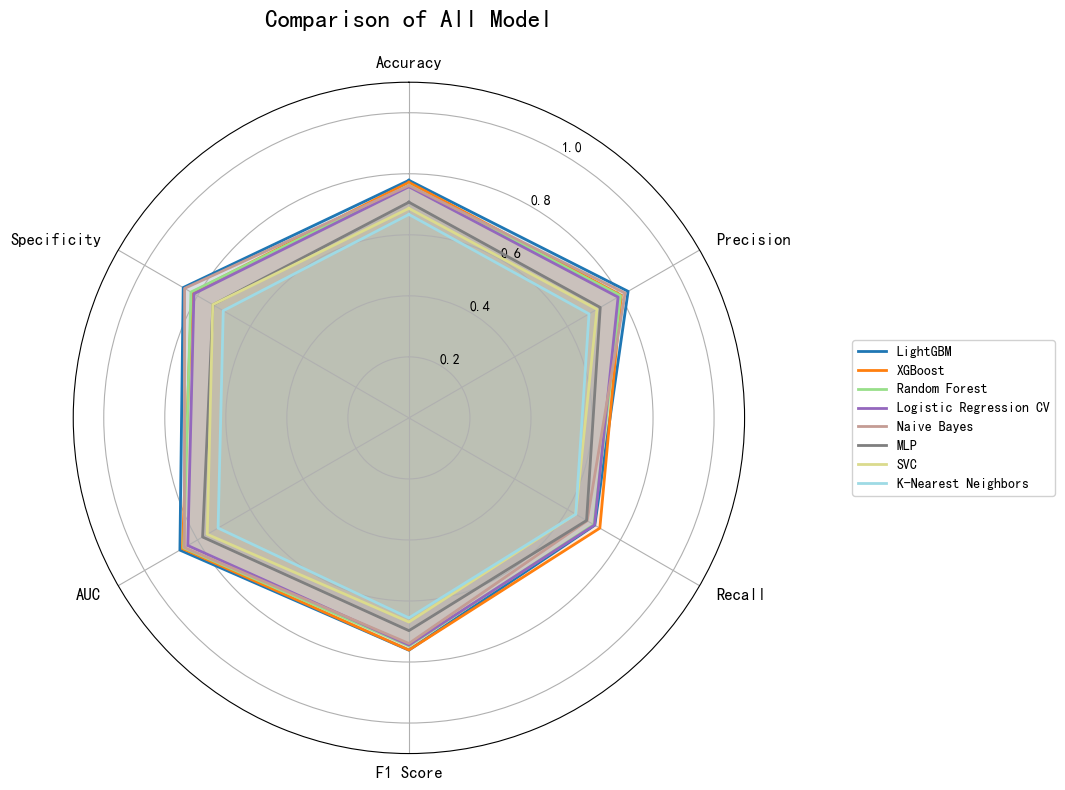

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi

def plot_radar_chart(df, title, save_path=None):
    """
    绘制改进后的雷达图，解决颜色重复和标签遮挡问题
    参数:
        df: 包含Model列和多个指标列的DataFrame
        title: 图表标题
        save_path: 图片保存路径（可选）
    """
    # 获取模型名称和指标
    models = df["Model"].values
    metrics = df.columns[1:]  # 去掉第一列的模型名称
    values = df[metrics].values

    # 计算角度
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # 闭合图形

    # 创建图形
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))
    
    # 使用不同的颜色映射确保颜色不重复
    colors = plt.cm.tab20(np.linspace(0, 1, len(models)))
    
    # 绘制雷达图（调整zorder确保标签不被遮挡）
    for i, model in enumerate(models):
        values_i = values[i].tolist()
        values_i += values_i[:1]  # 闭合图形
        ax.plot(angles, values_i, linewidth=2, label=model, color=colors[i], zorder=2)
        ax.fill(angles, values_i, alpha=0.15, color=colors[i], zorder=1)

    # 设置标签（优化防遮挡）
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics, fontsize=12)
    
    # 智能调整角标签位置
    for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
        if angle in [0, np.pi]:
            label.set_horizontalalignment('center')
        elif 0 < angle < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')
        label.set_verticalalignment('center')  # 垂直居中

    # 设置径向标签（确保显示在最上层）
    ax.set_rlabel_position(30)
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], 
              ["0.2", "0.4", "0.6", "0.8", "1.0"], 
              color="black", size=10, zorder=3)
    plt.ylim(0, 1.1)

    # 添加标题和图例
    ax.set_title(title, size=18, pad=20, fontweight='bold')
    ax.legend(loc='center left', bbox_to_anchor=(1.15, 0.5), 
             frameon=True, framealpha=0.9)
    
    # 调整布局
    plt.tight_layout()
    
    # 保存为矢量图
    if save_path:
        plt.savefig(save_path, format='svg', bbox_inches='tight', dpi=300)
    
    plt.show()

# 示例数据
data = {
    "Model": ["LightGBM", "XGBoost", "Random Forest", "Logistic Regression CV", "Naive Bayes", "MLP", "SVC", "K-Nearest Neighbors"],
    "Accuracy": [0.77855, 0.7719, 0.7620, 0.7576, 0.7613, 0.7068, 0.6865, 0.6668],
    "Precision": [0.8294, 0.8034, 0.8009, 0.7915, 0.8181, 0.7240, 0.7116,0.6815],
    "Recall": [0.7034, 0.7225, 0.6998, 0.7022, 0.6744, 0.6723, 0.6312, 0.6314],
    "F1 Score": [0.7612, 0.7608, 0.7470, 0.7442, 0.7393, 0.6972, 0.6690, 0.6555 ],
    "AUC": [0.8666, 0.8568, 0.8522, 0.8366, 0.8496, 0.7807, 0.7631, 0.7221],
    "Specificity": [0.8541, 0.8218, 0.8247, 0.8135, 0.8488, 0.7417, 0.7422, 0.7025]
}

df = pd.DataFrame(data)

# 绘制雷达图
plot_radar_chart(df, "Comparison of All Model", save_path="radar_chart.svg")

In [ ]:
import shap
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import os

# 模型训练
model = LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

save_dir = r"./output/SHAP_LightGBM"
os.makedirs(save_dir, exist_ok=True)

# Bar
plt.figure()
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False, max_display=20)
plt.title("LightGBM - Mean SHAP Feature Importance")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "LightGBM_shap_bar.png"))
plt.close()
 
# Beeswarm
plt.figure()
shap.summary_plot(shap_values, X_test, show=False, max_display=20)
plt.title("LightGBM - SHAP Summary Plot")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "LightGBM_shap_beeswarm.png"))
plt.close()

print("LightGBM SHAP plots saved.")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# 1. Data loading and preprocessing with SPARSE encoding
file_path = r"../tumordb/tumoragdb_data.csv"
data = pd.read_csv(file_path)
X_raw = data.iloc[:, 2:]
y = data['immunogenicity']

# 2. Data split BEFORE encoding (to avoid data leakage)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)

# 3. Sparse encoding
encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
X_train = encoder.fit_transform(X_train_raw.astype(str))
X_test = encoder.transform(X_test_raw.astype(str))
print(f"✓ Sparse encoding: {X_train.shape[1]:,} features")

# 4. Model training
model = LGBMClassifier(
    colsample_bytree=0.8,
    learning_rate=0.05,
    max_depth=7,
    min_child_samples=50,
    n_estimators=300,
    num_leaves=31,
    reg_alpha=0.1,
    reg_lambda=0.01,
    subsample=0.6,
    random_state=42,
    verbose=-1
)
model.fit(X_train, y_train)

# 5. SHAP analysis - Note: SHAP works with sparse matrices
explainer = shap.TreeExplainer(model)
# Use a sample of test data for SHAP (full test set may be too large)
X_test_sample = X_test[:1000]  # Sample 1000 for faster SHAP computation
shap_values = explainer(X_test_sample)

# Convert back to DataFrame for display (using feature names from encoder)
feature_names = encoder.get_feature_names_out()
X_test_sample_df = pd.DataFrame(X_test_sample.toarray(), columns=feature_names)

# 5.1 Feature importance bar chart
print("📊 LightGBM - Mean SHAP Feature Importance:")
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values.values, X_test_sample_df, plot_type="bar", max_display=10)
plt.tight_layout()
plt.show()

# 5.2 Feature influence distribution
print("🐝 LightGBM - SHAP Summary (Beeswarm) Plot:")
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values.values, X_test_sample_df, max_display=10)
plt.tight_layout()
plt.show()

# 5.3 Sample explanation
sample_idx = 0
if isinstance(explainer.expected_value, (list, np.ndarray)):
    expected_val = explainer.expected_value[1] if len(explainer.expected_value) > 1 else explainer.expected_value[0]
else:
    expected_val = explainer.expected_value

print("🔍 Sample Explanation:")
shap.plots.force(
    expected_val,
    shap_values.values[sample_idx, :],
    X_test_sample_df.iloc[sample_idx, :],
    matplotlib=True,
    figsize=(12, 3)
)

print("🔥 SHAP Heatmap (Balanced Random Samples):")
# Use smaller sample for heatmap (100 samples)
_, sample_X, _, sample_y = train_test_split(
    X_test_sample_df, y_test[:1000],
    train_size=100,
    stratify=y_test[:1000],
    random_state=42
)

# Compute SHAP for sample
sample_X_sparse = encoder.transform(X_test_raw.iloc[:100].astype(str))
shap_values_sample = explainer(sample_X_sparse)

print(f"Positive samples: {sum(sample_y)} | Negative samples: {len(sample_y)-sum(sample_y)}")

# Heatmap
shap.plots.heatmap(shap_values_sample, show=False)
plt.title(f"SHAP Heatmap (Random 100 Samples)\nPositive: {sum(sample_y)} | Negative: {len(sample_y)-sum(sample_y)}")
plt.gcf().set_size_inches(12, 8)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np

# Load and encode data with sparse matrices
file_path = r"../tumordb/tumoragdb_data.csv"
data = pd.read_csv(file_path)
X_raw = data.iloc[:, 2:]
y = data['immunogenicity']

# Split before encoding
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)

# Sparse encoding
encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
X_train = encoder.fit_transform(X_train_raw.astype(str))
X_test = encoder.transform(X_test_raw.astype(str))
print(f"✓ Encoded: {X_train.shape[1]:,} features (sparse)")

# ==================== LightGBM Hyperparameter Tuning ====================
print("\n" + "="*50)
print("LightGBM Hyperparameter Tuning")
print("="*50)

# Parameter grid (reduced for memory efficiency)
lgbm_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 9],
    'num_leaves': [31, 63],
    'min_child_samples': [20, 50],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],
    'reg_alpha': [0, 0.01],
    'reg_lambda': [0, 0.01]
}

# Grid search
lgbm_grid = GridSearchCV(
    estimator=LGBMClassifier(random_state=42, verbose=-1),
    param_grid=lgbm_param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

print("Running grid search...")
lgbm_grid.fit(X_train, y_train)

# Results
print("\n=== LightGBM Tuning Results ===")
print("Best parameters:", lgbm_grid.best_params_)
print("Best AUC:", lgbm_grid.best_score_)

# Retrain with best parameters
print("\nRetraining with best parameters...")
best_lgbm = lgbm_grid.best_estimator_
best_lgbm.fit(X_train, y_train)

# Evaluation
y_pred = best_lgbm.predict(X_test)
y_proba = best_lgbm.predict_proba(X_test)[:, 1]
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()

print("\n=== Test Set Performance ===")
print(f"Accuracy:    {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision:   {precision_score(y_test, y_pred):.4f}")
print(f"Recall:      {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score:    {f1_score(y_test, y_pred):.4f}")
print(f"AUC:         {roc_auc_score(y_test, y_proba):.4f}")
print(f"Specificity: {TN/(TN+FP):.4f}")

print("\nLightGBM tuning complete!")

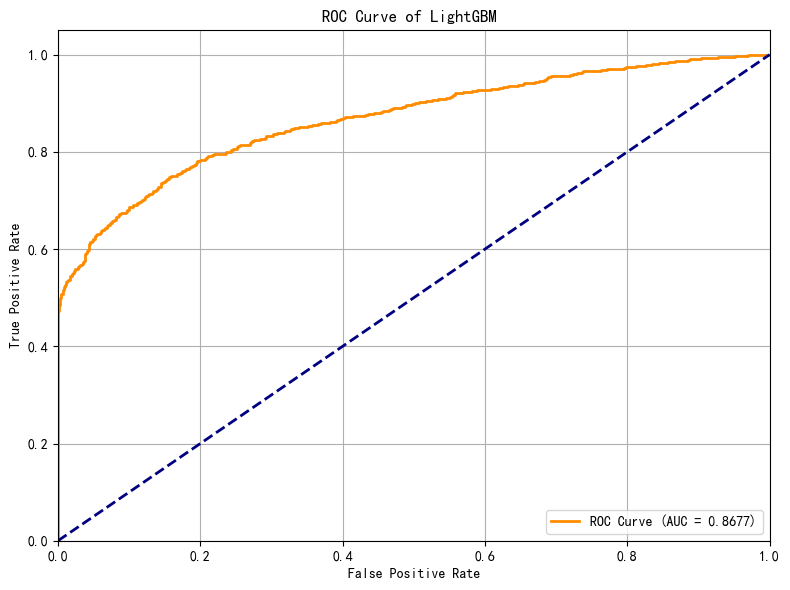

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 计算 ROC 曲线和 AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# 绘图
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 虚线为随机模型
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of LightGBM ')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [49]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier
import pandas as pd
import numpy as np

# 加载你的数据（这里用X,y代替，你需要替换为自己的数据）
# X = pd.read_csv(...)
# y = pd.read_csv(...)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==================== XGBoost 调参 ====================
print("\n" + "="*50)
print("XGBoost 调参开始")
print("="*50)

# 参数网格
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0, 0.01, 0.1]
}

# 网格搜索
xgb_grid = GridSearchCV(
    estimator=XGBClassifier(random_state=42, eval_metric='logloss'),
    param_grid=xgb_param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

print("正在进行网格搜索...")
xgb_grid.fit(X_train, y_train)

# 输出结果
print("\n=== XGBoost 调参结果 ===")
print("最佳参数:", xgb_grid.best_params_)
print("最佳AUC:", xgb_grid.best_score_)

# 使用最佳参数重新训练
print("\n使用最佳参数重新训练模型...")
best_xgb = xgb_grid.best_estimator_
best_xgb.fit(X_train, y_train)

# 评估指标
y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:, 1]
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()

print("\n=== 测试集表现 ===")
print(f"Accuracy:    {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision:   {precision_score(y_test, y_pred):.4f}")
print(f"Recall:      {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score:    {f1_score(y_test, y_pred):.4f}")
print(f"AUC:         {roc_auc_score(y_test, y_proba):.4f}")
print(f"Specificity: {TN/(TN+FP):.4f}")

print("\nXGBoost 调参完成！")


XGBoost 调参开始
正在进行网格搜索...
Fitting 5 folds for each of 19683 candidates, totalling 98415 fits

=== XGBoost 调参结果 ===
最佳参数: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 200, 'reg_alpha': 0.01, 'reg_lambda': 0, 'subsample': 0.6}
最佳AUC: 0.8760689073973698

使用最佳参数重新训练模型...

=== 测试集表现 ===
Accuracy:    0.7901
Precision:   0.8205
Recall:      0.7340
F1 Score:    0.7748
AUC:         0.8686
Specificity: 0.8445

XGBoost 调参完成！


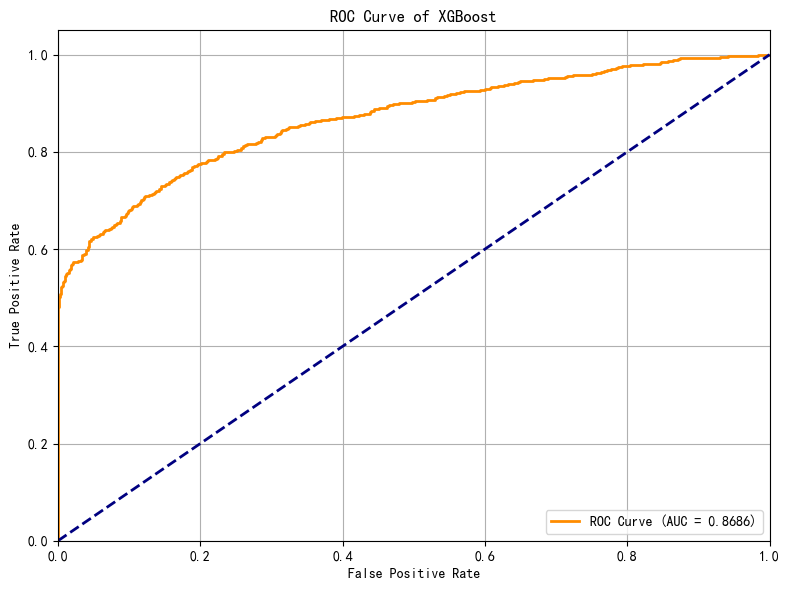

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 计算 ROC 曲线和 AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# 绘图
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 虚线为随机模型
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import shap
import numpy as np
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

# 1. 数据加载和预处理
file_path = r"../tumordb/tumoragdb_data.csv"
data = pd.read_csv(file_path)
X = data.iloc[:, 2:]
y = data['immunogenicity']

# 2. 数据划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. 模型训练
model = XGBClassifier(
    colsample_bytree= 1.0, gamma= 0.1, learning_rate= 0.05, max_depth= 5, min_child_weight= 3, n_estimators= 200, reg_alpha= 0.01, reg_lambda= 0, subsample= 0.6,
    random_state=42  # 添加随机种子确保可重复性
)
model.fit(X_train, y_train)

# 4. SHAP分析
# 统一使用测试集进行解释
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

# 4.1 特征重要性柱状图
print("📊 XGBoost - Mean SHAP Feature Importance:")
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values.values, X_test, plot_type="bar", max_display=10)
plt.tight_layout()
plt.show()

# 4.2 特征影响分布图
print("🐝 XGBoost - SHAP Summary (Beeswarm) Plot:")
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values.values, X_test, max_display=10)
plt.tight_layout()
plt.show()

# 4.3 单个样本解释
sample_idx = 0
if isinstance(explainer.expected_value, (list, np.ndarray)):
    expected_val = explainer.expected_value[1] if len(explainer.expected_value) > 1 else explainer.expected_value[0]
else:
    expected_val = explainer.expected_value

print("🔍 Sample Explanation:")
shap.plots.force(
    expected_val,
    shap_values.values[sample_idx, :],
    X_test.iloc[sample_idx, :],
    matplotlib=True,
    figsize=(12, 3)
)

print("🔥 SHAP Heatmap (Balanced Random Samples):")

# 按原始比例随机选取100个测试样本
_, sample_X, _, sample_y = train_test_split(
    X_test, y_test,
    train_size=100,
    stratify=y_test,  # 保持原始正负比例
    random_state=42
)

# 计算SHAP值
shap_values_sample = explainer(sample_X)

# 检查正负样本比例
print(f"正样本数: {sum(sample_y)} | 负样本数: {len(sample_y)-sum(sample_y)}")

# 绘制热力图
shap.plots.heatmap(shap_values_sample, show=False)
plt.title(f"SHAP Heatmap (Random 100 Samples)\nPositive: {sum(sample_y)} | Negative: {len(sample_y)-sum(sample_y)}")
plt.gcf().set_size_inches(12, 8)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import os
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# 加载数据
file_path = r"../tumordb/tumoragdb_data.csv"
data = pd.read_csv(file_path)
X = data.iloc[:, 2:]
y = data['immunogenicity']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练 XGBoost 模型
model = XGBClassifier(random_state=42, eval_metric='logloss')
model.fit(X_train, y_train)

# 计算 SHAP 值
explainer = shap.TreeExplainer(model)
shap_vals = explainer.shap_values(X_test)

# 提取 Top 5 特征
mean_abs_shap = np.abs(shap_vals).mean(axis=0)
top5_idx = np.argsort(mean_abs_shap)[-5:]
top5_names = X_test.columns[top5_idx]
X_top5 = X_test[top5_names]
shap_top5 = shap_vals[:, top5_idx]

# 输出目录
save_dir = r"./output/SHAP_XGBoost"
os.makedirs(save_dir, exist_ok=True)

# Bar 图
plt.figure()
shap.summary_plot(shap_top5, X_top5, plot_type="bar", show=False)
plt.title("XGBoost - Mean SHAP Value (Top 5 Features)")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "shap_bar_top5.png"))
plt.close()

# Beeswarm 图
plt.figure()
shap.summary_plot(shap_top5, X_top5, show=False)
plt.title("XGBoost - SHAP Beeswarm (Top 5 Features)")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "shap_beeswarm_top5.png"))
plt.close()

# 依赖图（前2个特征）
for feat in top5_names[:2]:
    plt.figure()
    shap.dependence_plot(feat, shap_vals, X_test, show=False)
    plt.title(f"SHAP Dependence Plot - {feat}")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"shap_dependence_{feat}.png"))
    plt.close()

# Force Plot（第一个样本）
force_plot = shap.force_plot(explainer.expected_value, shap_vals[0], X_test.iloc[0], matplotlib=False)
shap.save_html(os.path.join(save_dir, "shap_force_sample0.html"), force_plot)

print("XGBoost SHAP plots saved successfully.")

In [35]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

# 加载你的数据（这里用X,y代替，你需要替换为自己的数据）
# X = pd.read_csv(...)
# y = pd.read_csv(...)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==================== Random Forest 调参 ====================
print("\n" + "="*50)
print("Random Forest 调参开始")
print("="*50)

# 参数网格
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# 网格搜索
rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

print("正在进行网格搜索...")
rf_grid.fit(X_train, y_train)

# 输出结果
print("\n=== Random Forest 调参结果 ===")
print("最佳参数:", rf_grid.best_params_)
print("最佳AUC:", rf_grid.best_score_)

# 使用最佳参数重新训练
print("\n使用最佳参数重新训练模型...")
best_rf = rf_grid.best_estimator_
best_rf.fit(X_train, y_train)

# 评估指标
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()

print("\n=== 测试集表现 ===")
print(f"Accuracy:    {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision:   {precision_score(y_test, y_pred):.4f}")
print(f"Recall:      {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score:    {f1_score(y_test, y_pred):.4f}")
print(f"AUC:         {roc_auc_score(y_test, y_proba):.4f}")
print(f"Specificity: {TN/(TN+FP):.4f}")

print("\nRandom Forest 调参完成！")


Random Forest 调参开始
正在进行网格搜索...
Fitting 5 folds for each of 648 candidates, totalling 3240 fits

=== Random Forest 调参结果 ===
最佳参数: {'bootstrap': True, 'max_depth': None, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
最佳AUC: 0.8667964538815479

使用最佳参数重新训练模型...

=== 测试集表现 ===
Accuracy:    0.7862
Precision:   0.8291
Recall:      0.7123
F1 Score:    0.7663
AUC:         0.8599
Specificity: 0.8578

Random Forest 调参完成！


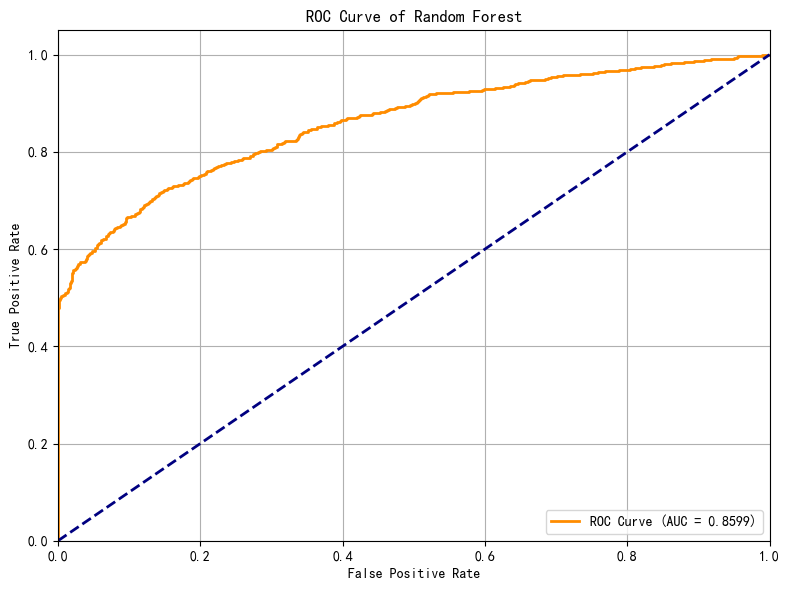

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 计算 ROC 曲线和 AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# 绘图
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 虚线为随机模型
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [83]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from joblib import dump

# 2. GradientBoosting
model_1 = RandomForestClassifier(
    n_estimators=300,
    max_depth=7,
    min_samples_split=2,
    min_samples_leaf=4,
    max_features=None,
    bootstrap=True,
    random_state=random_seed
)
model_1.fit(X_train, y_train)
predict_1 = model_1.predict(X_test)

# 3. LightGBM
model_2 = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    min_child_samples=50,
    subsample=0.6,
    colsample_bytree=0.8,
    # reg_alpha=0.012454972692882125,
    reg_lambda=0.01,
    random_state=random_seed
)
model_2.fit(X_train, y_train)
predict_2 = model_2.predict(X_test)

# 5. XGBoost
model_3 = XGBClassifier(
    n_estimators=200,
    learning_rate= 0.05,
    max_depth=5,
    min_child_weight=3,
    subsample=0.6,
    colsample_bytree=1.0,
    gamma=0.1,
    reg_alpha=0.01,
    reg_lambda=0,
    # subsample=0.6,
    random_state=random_seed,
)
model_3.fit(X_train, y_train)
predict_3 = model_3.predict(X_test)

# 保存模型
dump(model_1, 'RandomForest_model.joblib')
# dump(model_2, 'GBoost_model.joblib')
dump(model_2, 'LightGBM_model.joblib')
# dump(model_4, 'AdaBoost_model.joblib')
dump(model_3, 'XGBoost_model.joblib')

['XGBoost_model.joblib']

In [19]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np

# 1. 首先获取每个模型的类别预测(不是概率)
predict_1 = model_1.predict(X_test)  # RandomForest预测
predict_2 = model_2.predict(X_test)  # LightGBM预测
predict_3 = model_3.predict(X_test)  # XGBoost预测

# 2. 实现多数投票
def majority_voting(pred1, pred2, pred3, y_test):
    # 将三个模型的预测堆叠起来
    all_predictions = np.column_stack((pred1, pred2, pred3))
    
    # 对每个样本进行多数投票
    final_predictions = []
    for sample in all_predictions:
        # 统计0和1的票数
        counts = np.bincount(sample)
        # 取票数最多的类别(平局时取1)
        final_predictions.append(np.argmax(counts))
    
    # 转换为numpy数组
    final_predictions = np.array(final_predictions)
    
    # 计算评估指标
    acc = accuracy_score(y_test, final_predictions)
    pre = precision_score(y_test, final_predictions, zero_division=0)
    rec = recall_score(y_test, final_predictions, zero_division=0)
    f1 = f1_score(y_test, final_predictions, zero_division=0)
    
    # 对于多数投票，AUC需要概率，这里可以计算平均概率
    proba_avg = (model_1.predict_proba(X_test)[:,1] + 
                 model_2.predict_proba(X_test)[:,1] + 
                 model_3.predict_proba(X_test)[:,1]) / 3
    auc = roc_auc_score(y_test, proba_avg)
    
    # 计算特异度
    tn, fp, fn, tp = confusion_matrix(y_test, final_predictions).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    
    return {
        'Accuracy': acc,
        'Precision': pre,
        'Recall': rec,
        'F1': f1,
        'AUC': auc,
        'Specificity': specificity
    }

# 3. 调用多数投票函数
mv_results = majority_voting(predict_1, predict_2, predict_3, y_test)
print("多数投票结果:")
for metric, value in mv_results.items():
    print(f"{metric}: {value:.4f}")

多数投票结果:
Accuracy: 0.7940
Precision: 0.8368
Recall: 0.7222
F1: 0.7753
AUC: 0.8704
Specificity: 0.8635


In [ ]:
from itertools import product
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, confusion_matrix
)

def three_model_weighted_voting(proba_1, proba_2, proba_3, y_test, max_weight=10):
   
    weights_range = range(0, max_weight+1)  # 包含0权重
    weight_combinations = product(weights_range, repeat=3)
    
    # 转换为列表并去除全0组合
    weight_combinations = [w for w in weight_combinations if sum(w) > 0]
    
    # 预分配结果列表
    results = []
    
    # 遍历所有权重组合
    for a, b, c in tqdm(weight_combinations, desc="Evaluating weight combinations"):
        # 计算加权平均概率
        total = a + b + c
        y_score = (a * proba_1 + b * proba_2 + c * proba_3) / total
        
        # 概率转类别
        y_pred = (y_score >= 0.5).astype(int)
        
        # 计算评估指标
        acc = accuracy_score(y_test, y_pred)
        pre = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc = roc_auc_score(y_test, y_score)
        
        # 计算特异度
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        
        # 存储结果
        results.append({
            'Weight_Model1': a,
            'Weight_Model2': b,
            'Weight_Model3': c,
            'Accuracy': acc,
            'Precision': pre,
            'Recall': rec,
            'F1': f1,
            'AUC': auc,
            'Specificity': specificity
        })
    
    return pd.DataFrame(results)

# 使用示例
# 首先获取各模型的概率预测(确保是正类的概率)
proba_1 = model_1.predict_proba(X_test)[:, 1]  # 模型1的概率
proba_2 = model_2.predict_proba(X_test)[:, 1]  # 模型2的概率
proba_3 = model_3.predict_proba(X_test)[:, 1]  # 模型3的概率

# 运行加权投票
results_df = three_model_weighted_voting(proba_1, proba_2, proba_3, y_test, max_weight=10)

# 按AUC排序并显示最佳组合
best_combinations = results_df.sort_values(by='AUC', ascending=False)
print("最佳权重组合:")
print(best_combinations.head(10))

Evaluating weight combinations: 100%|██████████| 1330/1330 [00:08<00:00, 147.93it/s]

最佳权重组合:
     Weight_Model1  Weight_Model2  Weight_Model3  Accuracy  Precision  \
580              4              8              9  0.794474   0.833145   
712              5              9              9  0.793505   0.832018   
302              2              5              6  0.795444   0.832772   
301              2              5              5  0.795444   0.835028   
603              4             10             10  0.795444   0.835028   
435              3              6              7  0.793989   0.832207   
591              4              9              9  0.794474   0.833145   
567              4              7              7  0.793505   0.832018   
592              4              9             10  0.794474   0.833145   
724              5             10             10  0.794474   0.833145   

       Recall        F1       AUC  Specificity  
580  0.728079  0.777077  0.870738     0.858779  
712  0.727094  0.776025  0.870717     0.857824  
302  0.731034  0.778594  0.870713     0.8

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# 1. 加载独立数据集（先上传）
# NOTE: Update this path to point to your independent dataset when available
# independent_data = pd.read_csv(r"Independent dataset.csv")

# 2. 数据拆分
# y_independent = independent_data.iloc[:, 1]
# X_independent = independent_data.iloc[:, 2:]

# 3. 使用训练好的模型进行预测（这里只演示结构，需确保模型已fit）
# 示例：model_1.predict_proba(X_independent)[:, 1]
# proba_1 = model_1.predict_proba(X_independent)[:, 1]
# proba_2 = model_2.predict_proba(X_independent)[:, 1]
# proba_3 = model_3.predict_proba(X_independent)[:, 1]

# 4. 加权融合
# weights = {
#     'RandomForestClassifier': 4,
#     'LGBMClassifier': 8,
#     'XGBClassifier': 9
# }
# total = sum(weights.values())

# y_score = (
#     weights['RandomForestClassifier'] * proba_1 +
#     weights['LGBMClassifier'] * proba_2 +
#     weights['XGBClassifier'] * proba_3 
# ) / total

# y_pred = np.where(y_score >= 0.5, 1, 0)

# 5. 评估
# acc = accuracy_score(y_independent, y_pred)
# prec = precision_score(y_independent, y_pred)
# rec = recall_score(y_independent, y_pred)
# f1 = f1_score(y_independent, y_pred)
# auc = roc_auc_score(y_independent, y_score)
# tn, fp, fn, tp = confusion_matrix(y_independent, y_pred).ravel()
# specificity = tn / (tn + fp)

# 6. 输出
# print("模型在独立数据集的表现：")
# print(f"Accuracy:    {acc:.4f}")
# print(f"Precision:   {prec:.4f}")
# print(f"Recall:      {rec:.4f}")
# print(f"F1 Score:    {f1:.4f}")
# print(f"AUC:         {auc:.4f}")
# print(f"Specificity: {specificity:.4f}")

print("Independent dataset validation cell - uncomment and update path when you have an independent dataset to validate.")